# Preparing data

In [26]:
import pandas as pd
import numpy as np

In [3]:
data_train = pd.read_csv('data/train.csv',index_col='id',na_values=-1)
data_test = pd.read_csv('data/test.csv',index_col='id',na_values=-1)

In [4]:
cat_feat = data_test.filter(like='cat', axis=1).columns.values.tolist()
bin_feat = data_test.filter(like='bin', axis=1).columns.values.tolist()
num_feat = list(set(list(data_test)) - set(cat_feat)- set(bin_feat))

features_names = cat_feat + bin_feat + num_feat

In [5]:
def Transform(train, fill_na=0, drop_first= False, drop_ps_car_11_cat=False):
    
    cat_f = ['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']
    bin_f = ['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin', 'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin', 'ps_calc_19_bin', 'ps_calc_20_bin']
    # Becarefull here we let the target in the training set
    num_f = ['target','ps_car_12', 'ps_calc_12', 'ps_calc_09', 'ps_calc_03', 'ps_calc_11', 'ps_calc_13', 'ps_reg_01', 'ps_calc_06', 'ps_calc_04', 'ps_car_14', 'ps_calc_08', 'ps_car_13', 'ps_calc_01', 'ps_reg_02', 'ps_calc_10', 'ps_calc_05', 'ps_reg_03', 'ps_ind_01', 'ps_calc_02', 'ps_car_15', 'ps_car_11', 'ps_calc_14', 'ps_ind_03', 'ps_ind_14', 'ps_ind_15', 'ps_calc_07']
    
    if drop_ps_car_11_cat : cat_f.remove('ps_car_11_cat')
        
    for var in bin_feat + cat_feat:
        train[var] = train[var].astype('float')
        
    train_cnt = train[num_f].fillna(fill_na) # On remlace les valeurs manquantes par 0 (Il semblerait que xgboost les gère mieux comme ça).
    train_bin = train[bin_f]
    train_cat = pd.get_dummies(train[cat_f],
                              prefix_sep='#',
                              drop_first=drop_first)

    return pd.concat([train_cnt, train_bin, train_cat], axis=1);

In [6]:
Train_mod = Transform(data_train, fill_na=0, drop_first= False, drop_ps_car_11_cat= True)
#Test_mod = Transform(data_test, fill_na=0, drop_first= False, drop_ps_car_11_cat= True)

In [7]:
y = data_train['target']

In [8]:
from sklearn.model_selection import train_test_split
train, X_t, y_train, y_t = train_test_split(Train_mod, y, stratify=y, test_size=0.95, random_state=42)

In [9]:
target = 'target'

In [10]:
predictors = [x for x in train.columns if x not in [target]]

# XGBoost tunning on a small trainning set

In [11]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

/Users/rafik/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/rafik/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [12]:
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [13]:
def gini(pred, y):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def normalized_gini(pred, y):
    return gini(pred, y) / gini(y, y)

# custom normalized gini score for xgb model
def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', normalized_gini(pred, y)

In [30]:
alg = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)

In [34]:
dtrain = train
cv_folds = 5
early_stopping_rounds=50

xgb_param = alg.get_xgb_params()
xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
cvresult = xgb.cv(xgb_param,
                          xgtrain,
                          num_boost_round = alg.get_params()['n_estimators'],
                          nfold = cv_folds,
                          #metrics='auc',
                          feval = gini_xgb,
                          maximize = True,
                          early_stopping_rounds = early_stopping_rounds,
                          verbose_eval = 10,
                          #show_progress=False
                         )

[0]	train-gini:0.138362+0.0238683	test-gini:0.106939+0.0407998
[10]	train-gini:0.356099+0.013853	test-gini:0.19083+0.0528064
[20]	train-gini:0.443891+0.0124959	test-gini:0.195588+0.0459765
[30]	train-gini:0.538193+0.0113344	test-gini:0.197254+0.0469281
[40]	train-gini:0.614086+0.012138	test-gini:0.192323+0.0506466
[50]	train-gini:0.676309+0.00408656	test-gini:0.200599+0.0443999
[60]	train-gini:0.718812+0.012155	test-gini:0.192349+0.0509973
[70]	train-gini:0.764518+0.0164875	test-gini:0.189501+0.0514858
[80]	train-gini:0.794007+0.0182592	test-gini:0.185709+0.0465329
[90]	train-gini:0.819854+0.0179896	test-gini:0.180469+0.0480905


SyntaxError: invalid syntax (<ipython-input-36-eec732182d3c>, line 2)

In [22]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param,
                          xgtrain,
                          num_boost_round = alg.get_params()['n_estimators'],
                          nfold = cv_folds,
                          #metrics='auc',
                          feval = gini_xgb,
                          maximize = True,
                          early_stopping_rounds = early_stopping_rounds,
                          verbose_eval = 10,
                          #show_progress=False
                         )
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['target'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['target'], dtrain_predprob))
    print ("gini Score (Train): %f" % normalized_gini(dtrain['target'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [24]:
xgb1 = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27)


Model Report
Accuracy : 0.9637
AUC Score (Train): 0.814033
gini Score (Train): 0.164522


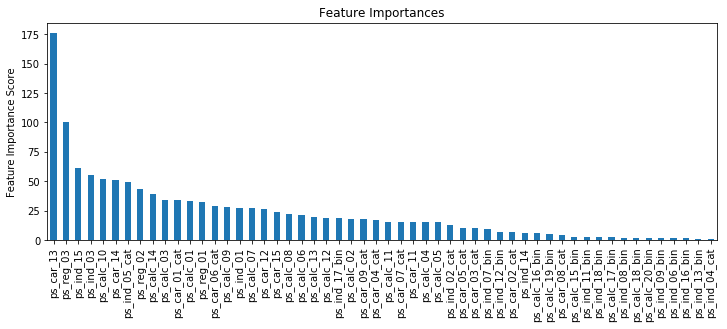

In [29]:
modelfit(xgb1, train, predictors,useTrainCV=False)

In [58]:
param_test1 = {
 'max_depth':[3,10,2],
 'min_child_weight':[1,6,2]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1,
                                                  n_estimators=140,
                                                  max_depth=5,
                                                  min_child_weight=1,
                                                  gamma=0,
                                                  subsample=0.8,
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic',
                                                  nthread=4,
                                                  scale_pos_weight=1,
                                                  seed=27),
                        param_grid = param_test1,
                        scoring='roc_auc',
                        n_jobs=4,
                        iid=False,
                        cv=5)

gsearch1.fit(train[predictors],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_


([mean: 0.60691, std: 0.01548, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.60998, std: 0.01269, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: 0.61044, std: 0.01589, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.56585, std: 0.02289, params: {'max_depth': 10, 'min_child_weight': 1},
  mean: 0.56234, std: 0.00984, params: {'max_depth': 10, 'min_child_weight': 6},
  mean: 0.56524, std: 0.01804, params: {'max_depth': 10, 'min_child_weight': 2},
  mean: 0.61365, std: 0.01539, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.61134, std: 0.01496, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: 0.61624, std: 0.01474, params: {'max_depth': 2, 'min_child_weight': 2}],
 {'max_depth': 2, 'min_child_weight': 2},
 0.6162432954732642)